# Quantitative Trading Strategies Using Python
## Technical Analysis, Statistical Testing,and Machine Learning
—
### Peng Liu

#######################################################################################################################

## CHAPTER 3 
## Forward and Futures Contracts

### Working with Futures Data

##### Downloading futures data For visualisation

In [ ]:
!pip install botorch
!pip install -U statsmodels
!pip install ta
!pip install yfinance
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition import qExpectedImprovement
from botorch.acquisition import UpperConfidenceBound
from botorch.acquisition.knowledge_gradient import qKnowledgeGradient
from botorch.fit import fit_gpytorch_mll
from bs4 import BeautifulSoup
from datetime import datetime
from dateutil.relativedelta import relativedelta
from itertools import combinations
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
import requests
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import ta
import torch
import torch.nn as nn
import yfinance as yf

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [ ]:
plt.style.use('dark_background')
%matplotlib inline
# Download the platinum prices
futures_data = yf.download("PL=F", start="2022-01-01", end="2022-12-31")
# Set the index to a datetime type
futures_data.index = pd.to_datetime(futures_data.index)

In [ ]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

##### Visualizing the futures data

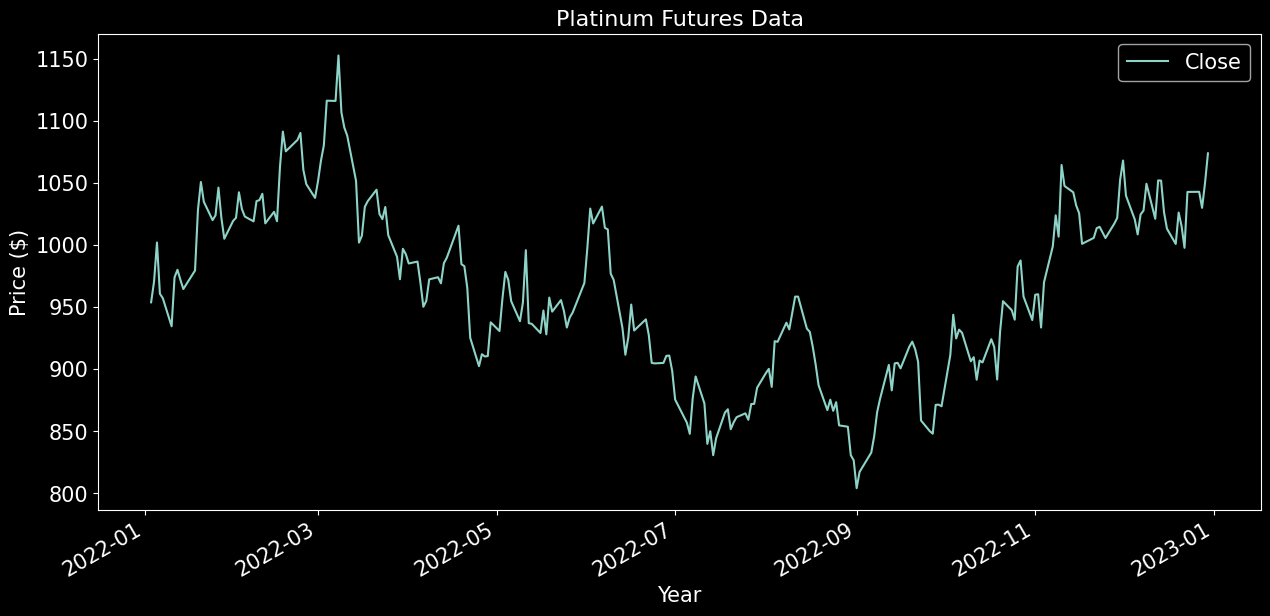

In [ ]:
# Plot the close price
plt.figure(figsize=(15, 7))
futures_data['Adj Close'].plot()
# Set labels and sizes of the title and axis
plt.title('Platinum Futures Data', fontsize=16)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Price ($)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Close'], prop={'size': 15})
# Show the plot
plt.show()

##### Downloading multiple futures

In [ ]:
# Fetch gold and copper futures prices
futures_data = yf.download(["GC=F","HG=F"], start="2022-01-01",
end="2022-12-31", group_by= 'tickers')
# Set the index to a datetime type
futures_data.index = pd.to_datetime(futures_data.index)
# Display the last five rows
futures_data.tail()

[*********************100%%**********************]  2 of 2 completed


Ticker        HG=F                                                  GC=F  \
Price         Open    High     Low   Close Adj Close Volume         Open   
Date                                                                       
2022-12-23  3.7835  3.8110  3.7600  3.8030    3.8030    370  1794.300049   
2022-12-27  3.8640  3.9280  3.8335  3.8335    3.8335    380  1803.400024   
2022-12-28  3.8420  3.8420  3.8190  3.8320    3.8320    550  1803.199951   
2022-12-29  3.8310  3.8425  3.8090  3.8210    3.8210    723  1805.800049   
2022-12-30  3.8265  3.8315  3.8020  3.8055    3.8055    681  1817.000000   

Ticker                                                                 
Price              High          Low        Close    Adj Close Volume  
Date                                                                   
2022-12-23  1802.800049  1794.099976  1795.900024  1795.900024     49  
2022-12-27  1826.300049  1803.400024  1814.800049  1814.800049     69  
2022-12-28  1807.900024  1803.099976  1807.900024  1807.900024    434  
2022-12-29  1819.500000  1805.800049  1819.500000  1819.500000    277  
2022-12-30  1822.300049  1816.800049  1819.699951  1819.699951     95

##### Visualizing multiple futures time series

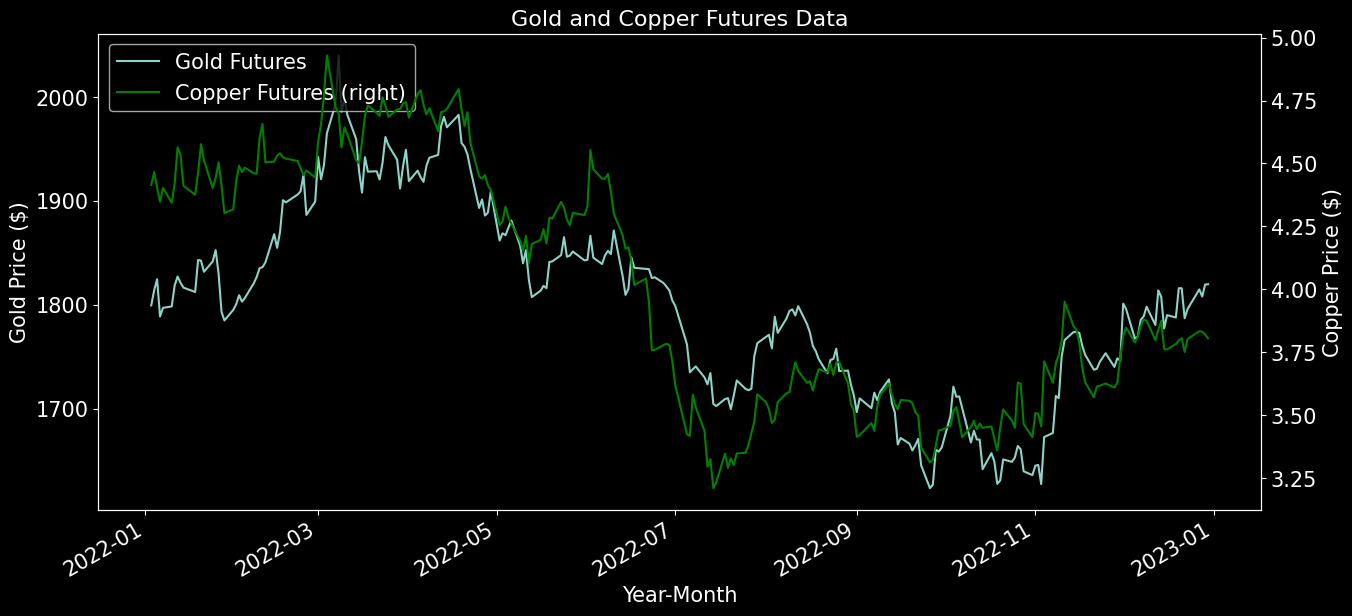

In [ ]:
# Set the figure size
ax = plt.figure(figsize=(15, 7))
# Plot both futures close prices
ax = futures_data['GC=F']['Close'].plot(label='Gold Futures')
ax2 = futures_data['HG=F']['Close'].plot(secondary_y=True,
color='g', ax=ax, label='Copper Futures')
# Set the title and axis labels and sizes
plt.title('Gold and Copper Futures Data', fontsize=16)
ax.set_xlabel('Year-Month', fontsize=15)
ax.set_ylabel('Gold Price ($)', fontsize=15)
ax2.set_ylabel('Copper Price ($)', fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc=2, prop={'size': 15})
# Show the plot
plt.show()

#### Adding Technical Indicators

##### Downloading S&P 500 E-Mini futures data

In [ ]:
futures_symbol = "ES=F"
futures_data = yf.download(futures_symbol, start="2022-01-01",
end="2022-04-01", interval="1d")

[*********************100%%**********************]  1 of 1 completed


##### Calculating common technical indicators

In [ ]:
# Calculate RSI
futures_data["RSI"] = ta.momentum.RSIIndicator(futures_data["Close"]).rsi()
# Calculate Bollinger Bands
bbands = ta.volatility.BollingerBands(futures_data["Close"])
futures_data["BB_upper"] = bbands.bollinger_hband()
futures_data["BB_lower"] = bbands.bollinger_lband()
# Calculate MACD
macd = ta.trend.MACD(futures_data["Close"])
futures_data["MACD"] = macd.macd()
futures_data["MACD_signal"] = macd.macd_signal()

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


##### Visualizing futures data and technical indicators

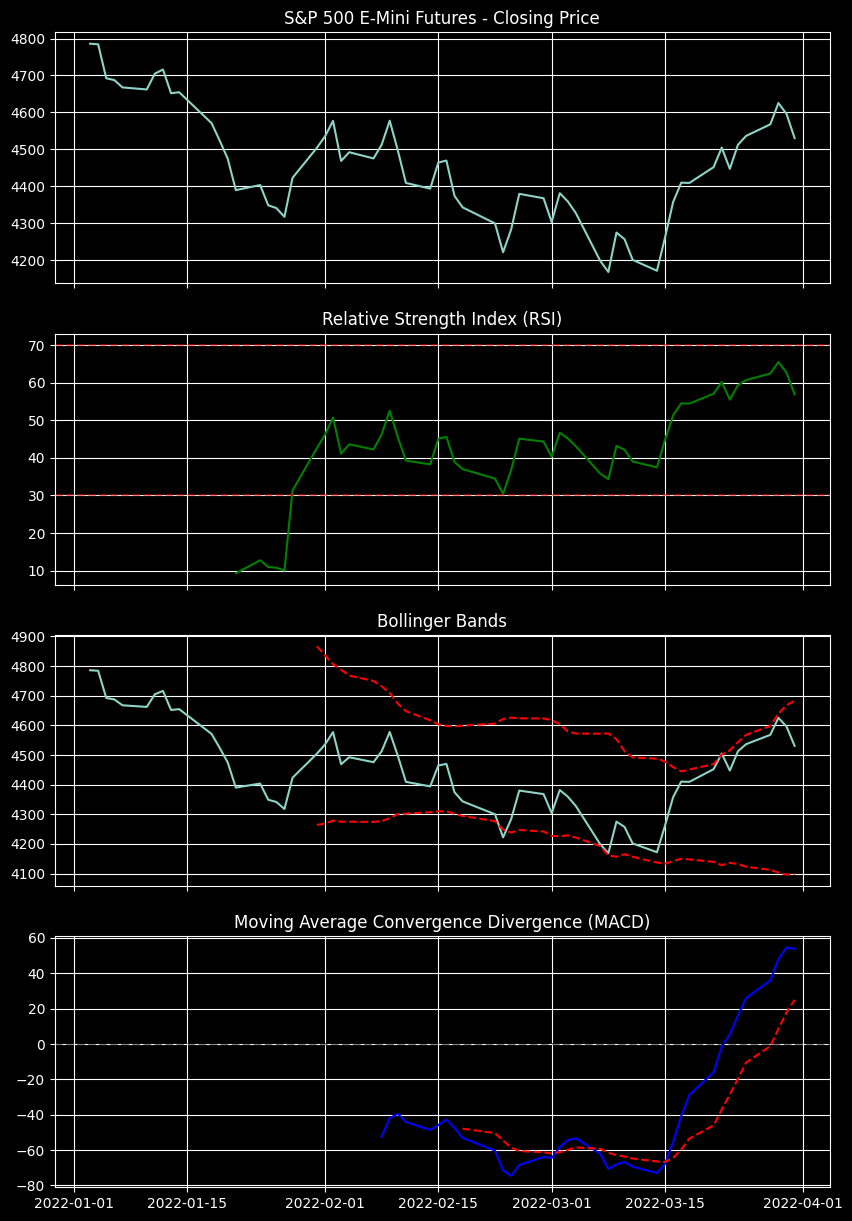

In [ ]:
# Create subplots for each indicator
fig, axes = plt.subplots(4, 1, figsize=(10, 15), sharex=True)
# Plot closing price
axes[0].plot(futures_data.index, futures_data["Close"], label="Close")
axes[0].set_title("S&P 500 E-Mini Futures - Closing Price")
axes[0].grid()

# Plot RSI
axes[1].plot(futures_data.index, futures_data["RSI"], label="RSI",
color="g")
axes[1].axhline(30, linestyle="--", color="r", alpha=0.5)
axes[1].axhline(70, linestyle="--", color="r", alpha=0.5)
axes[1].set_title("Relative Strength Index (RSI)")
axes[1].grid()

# Plot Bollinger Bands
axes[2].plot(futures_data.index, futures_data["Close"], label="Close")
axes[2].plot(futures_data.index, futures_data["BB_upper"], label="Upper Bollinger Band", linestyle="--", color="r")
axes[2].plot(futures_data.index, futures_data["BB_lower"], label="Lower Bollinger Band", linestyle="--", color="r")
axes[2].set_title("Bollinger Bands")
axes[2].grid()

# Plot MACD
axes[3].plot(futures_data.index, futures_data["MACD"], label="MACD",
color="b")
axes[3].plot(futures_data.index, futures_data["MACD_signal"], label="Signal Line", linestyle="--", color="r")
axes[3].axhline(0, linestyle="--", color="k", alpha=0.5)
axes[3].set_title("Moving Average Convergence Divergence (MACD)")
axes[3].grid()

########################################################################################################################